In [57]:
import numpy as np
import pandas as pd
import re
import os
import json


In [2]:
occupation_dict = {
    0:  "other",
    1:  "academic or educator",
    2:  "artist",
    3:  "clerical or admin",
    4:  "college or grad student",
    5:  "customer service",
    6:  "doctor or health care",
    7:  "executive or managerial",
    8:  "farmer",
    9:  "homemaker",
    10:  "student",
    11:  "lawyer",
    12:  "programmer",
    13:  "retired",
    14:  "sales or marketing",
    15:  "scientist",
    16:  "self-employed",
    17:  "technician or engineer",
    18:  "tradesman or craftsman",
    19:  "unemployed",
    20:  "writer"
}


In [3]:
rating = pd.read_csv("/home/yuqihang/workroot/models/data/recsys/ml1m/ratings.dat",header=None, sep='::', names=['uid','iid','rating','timestamp'],engine='python')
item_info = pd.read_csv("/home/yuqihang/workroot/models/data/recsys/ml1m/movies.dat",sep='::',encoding='latin-1',engine='python',names=['iid','title','genres'])
user_info = pd.read_csv("/home/yuqihang/workroot/models/data/recsys/ml1m/users.dat",sep='::',encoding='latin-1',engine='python',names=['uid','gender','age','occupation','zipcode'])

In [4]:
item_info['title'] = item_info['title'].map(lambda x: re.sub(r'\s+\((\d+)\)','',x))
item_info['description'] = item_info['genres'].map(lambda x: x.replace('|',', '))
del item_info['genres']
item_info.head()

,iid,title,description
0,1,Toy Story,"Animation, Children's, Comedy"
1,2,Jumanji,"Adventure, Children's, Fantasy"
2,3,Grumpier Old Men,"Comedy, Romance"
3,4,Waiting to Exhale,"Comedy, Drama"
4,5,Father of the Bride Part II,Comedy


In [5]:
rating.head(2)

,uid,iid,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109


In [6]:
user_info['occupation'] = user_info['occupation'].apply(lambda x: occupation_dict[x])
user_info.head(2)

,uid,gender,age,occupation,zipcode
0,1,F,1,student,48067
1,2,M,56,self-employed,70072


In [7]:
rating_ = pd.merge(rating,item_info,on='iid',how='inner')

In [8]:
rating_.head(2)

,uid,iid,rating,timestamp,title,description
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest,Drama
1,2,1193,5,978298413,One Flew Over the Cuckoo's Nest,Drama


In [9]:
date_min = pd.to_datetime(rating_.timestamp,unit='s').min() 
date_max = pd.to_datetime(rating_.timestamp,unit='s').max()
date_min,date_max

(Timestamp('2000-04-25 23:05:32'), Timestamp('2003-02-28 17:49:50'))

In [10]:
(date_max.year-date_min.year)*12+date_max.month

38

In [11]:
rating_['time'] = pd.to_datetime(rating_.timestamp,unit='s').map(lambda x: (x.year-date_min.year)*12+x.month)

In [12]:
rating_.head(2)

,uid,iid,rating,timestamp,title,description,time
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest,Drama,12
1,2,1193,5,978298413,One Flew Over the Cuckoo's Nest,Drama,12


In [13]:
rating_['time'] = rating_['time'] - rating_['time'].min()

In [14]:
np.sort(rating_.time.unique())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34])

In [15]:
rating_.head(2)

,uid,iid,rating,timestamp,title,description,time
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest,Drama,8
1,2,1193,5,978298413,One Flew Over the Cuckoo's Nest,Drama,8


<Axes: xlabel='time'>

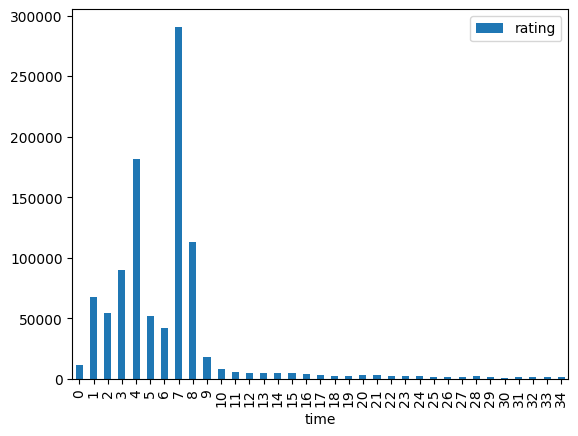

In [16]:
rating_.groupby('time').agg({'rating':'count'}).reset_index().plot(x='time',kind='bar')

In [17]:
rating_.head(2)

,uid,iid,rating,timestamp,title,description,time
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest,Drama,8
1,2,1193,5,978298413,One Flew Over the Cuckoo's Nest,Drama,8


In [18]:
train_slot = list(range(14,24))
valid_slot = list(range(24,29))
test_slot = list(range(29,34))

In [19]:
rating_['label'] = rating_['rating'].apply(lambda x: 1 if x>=4 else 0)
rating_.head(5)

,uid,iid,rating,timestamp,title,description,time,label
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest,Drama,8,1
1,2,1193,5,978298413,One Flew Over the Cuckoo's Nest,Drama,8,1
2,12,1193,4,978220179,One Flew Over the Cuckoo's Nest,Drama,8,1
3,15,1193,4,978199279,One Flew Over the Cuckoo's Nest,Drama,8,1
4,17,1193,5,978158471,One Flew Over the Cuckoo's Nest,Drama,8,1


In [20]:
rating_.label.describe()

count    1.000209e+06
mean     5.751608e-01
std      4.943188e-01
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: label, dtype: float64

In [21]:
rating_.uid.min(),rating_.uid.max(),rating_.iid.min(),rating_.iid.max()

(1, 6040, 1, 3952)

In [23]:
users = rating_.uid.unique()
items = rating_.iid.unique()
users_map = dict(zip(users, np.arange(users.shape[0])+1))
items_map = dict(zip(items, np.arange(items.shape[0])+1))
users_map[0]=0
items_map[0]=0

In [26]:
rating_.head(2)

,uid,iid,rating,timestamp,title,description,time,label
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest,Drama,8,1
1,2,1193,5,978298413,One Flew Over the Cuckoo's Nest,Drama,8,1


In [27]:
rating_['uid'] = rating_['uid'].map(users_map)
rating_['iid'] = rating_['iid'].map(items_map)
rating_.head(2)

,uid,iid,rating,timestamp,title,description,time,label
0,1,1,5,978300760,One Flew Over the Cuckoo's Nest,Drama,8,1
1,2,1,5,978298413,One Flew Over the Cuckoo's Nest,Drama,8,1


In [32]:
id2title = {}
# title2id = {}
for i in range(len(rating_)):
    iid = int(rating_.iloc[i]['iid'])
    title = str(rating_.iloc[i]['title'])
    description = str(rating_.iloc[i]['description'])
    if iid not in id2title:
        id2title[iid] = {
            'title':title,
            'keywords':description
            }
print(len(id2title.keys()))

3706


In [33]:
json_dir = '/home/yuqihang/workroot/models/data/collm/ml1m'
json.dump(id2title, open(f"{json_dir}/id2title.json", "w"), indent=4)

## split by time order

In [34]:
rating_.head()

,uid,iid,rating,timestamp,title,description,time,label
0,1,1,5,978300760,One Flew Over the Cuckoo's Nest,Drama,8,1
1,2,1,5,978298413,One Flew Over the Cuckoo's Nest,Drama,8,1
2,3,1,4,978220179,One Flew Over the Cuckoo's Nest,Drama,8,1
3,4,1,4,978199279,One Flew Over the Cuckoo's Nest,Drama,8,1
4,5,1,5,978158471,One Flew Over the Cuckoo's Nest,Drama,8,1


In [35]:
rating_train = rating_[rating_['time'].isin(train_slot)].copy()
rating_valid = rating_[rating_['time'].isin(valid_slot)].copy()
rating_test = rating_[rating_['time'].isin(test_slot)].copy()

In [36]:
rating_train.shape, rating_valid.shape, rating_test.shape

((33891, 8), (10401, 8), (7331, 8))

In [37]:
rating_valid_f = rating_valid
rating_test_f = rating_test

In [38]:
def filter_cold_start(train,valid,test):
    train_user = train.uid.unique()
    train_item = train.iid.unique()
    valid = valid[valid['uid'].isin(train_user)]
    test = test[test['uid'].isin(train_user)]
    valid = valid[valid['iid'].isin(train_item)]
    test = test[test['iid'].isin(train_item)]
    return valid, test

In [39]:
rating_valid_f.label.mean(), rating_valid.label.mean(), rating_test_f.label.mean() 

(0.5283145851360446, 0.5283145851360446, 0.5453553403355613)

In [40]:
rating_valid_f.columns

Index(['uid', 'iid', 'rating', 'timestamp', 'title', 'description', 'time',
       'label'],
      dtype='object')

In [41]:
import copy
def deal_with_each_u_both(x,u):
    items = np.array(x.iid)
    labels = np.array(x.label)
    titles = np.array(x.title)
    descriptions = np.array(x.description)
    timestamp = np.array(x.timestamp)
    flags =  np.array(x.flag) 
    his = [0] # adding a '0' by default
    his_label = [0]
    results = []
    for i in range(items.shape[0]):
        results.append((u, items[i], timestamp[i], np.array(his), np.array(his_label), labels[i], flags[i]))
        his.append(items[i])
        his_label.append(labels[i])
    return results

def deal_with_each_u(x,u):
    items = np.array(x.iid)
    labels = np.array(x.label)
    titles = np.array(x.title)
    descriptions = np.array(x.description)
    timestamp = np.array(x.timestamp)
    flags =  np.array(x.flag) 
    his = [0] # adding a '0' by default
    results = []
    for i in range(items.shape[0]):
        results.append((u, items[i], timestamp[i], np.array(his), labels[i], flags[i]))
        if labels[i] > 0: # positive 
            his.append(items[i])
    return results

In [42]:
rating_train = rating_train.copy()

In [43]:
rating_train['flag'] =  pd.DataFrame(np.ones(rating_train.shape[0])*-1, index=rating_train.index)
rating_valid_f['flag'] = pd.DataFrame(np.zeros(rating_valid_f.shape[0]), index=rating_valid_f.index)
rating_test_f['flag'] = pd.DataFrame(np.ones(rating_test_f.shape[0]), index=rating_test_f.index)
data = pd.concat([rating_train, rating_valid_f, rating_test_f],axis=0,ignore_index=True)
data = data.sort_values(by=['uid','timestamp'])
u_inter_all = data.groupby('uid').agg({'iid':list, 'label':list, 'title':list, 'timestamp':list, 'description':list, 'flag':list})

In [44]:
data.flag.unique()

array([-1.,  1.,  0.])

In [45]:
results = []
results_both = []
for u in u_inter_all.index:
    results.extend(deal_with_each_u(u_inter_all.loc[u],u))
    results_both.extend(deal_with_each_u_both(u_inter_all.loc[u],u))

In [46]:
def list2pd(seqs):
    u_, i_, time_, label_, his_, flag_ = [],[],[],[],[],[]
    if len(seqs[0]) == 7:
        his_label_ = []
    for re_ in seqs:
        u_.append(re_[0])
        i_.append(re_[1])
        time_.append(re_[2])
        his_.append(re_[3])
        if len(seqs[0]) == 7:
            his_label_.append(re_[4])
        label_.append(re_[-2])
        flag_.append(re_[-1])
    columns = {"uid":u_,'iid':i_,'label':label_, 'timestamp': time_ , 'his':his_, 'flag': flag_}
    if len(seqs[0]) == 7:
        columns['his_label']=his_label_
    return pd.DataFrame(columns)

In [31]:
# u_, i_, time_, label_, his_, his_title, title_,flag_ = [],[],[],[],[],[],[],[]
# for re_ in results:
#     u_.append(re_[0])
#     i_.append(re_[1])
#     time_.append(re_[2])
#     his_.append(re_[3])
#     his_title.append(re_[4])
#     title_.append(re_[5])
#     label_.append(re_[6])
#     flag_.append(re_[7])

In [32]:
# data = pd.DataFrame({"uid":u_,'iid':i_,'label':label_, 'timestamp': time_ , 'his':his_,'his_title':his_title,'title':title_, 'flag': flag_})


In [64]:
data = list2pd(results_both)

In [65]:
data.head(2)

,uid,iid,label,timestamp,his,flag,his_label
0,7,168,1,994556598,[0],-1.0,[0]
1,7,771,1,994556636,"[0, 168]",-1.0,"[0, 1]"


In [66]:
data.label.describe()

count    51623.000000
mean         0.536273
std          0.498687
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: label, dtype: float64

In [67]:
data.tail(5)

,uid,iid,label,timestamp,his,flag,his_label
51618,5944,754,0,1004919134,"[0, 172, 547, 93, 116, 327, 417, 1476, 1896, 1...",-1.0,"[0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ..."
51619,5944,1076,0,1004919134,"[0, 172, 547, 93, 116, 327, 417, 1476, 1896, 1...",-1.0,"[0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ..."
51620,5944,1089,0,1004919134,"[0, 172, 547, 93, 116, 327, 417, 1476, 1896, 1...",-1.0,"[0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ..."
51621,5944,1073,0,1004919188,"[0, 172, 547, 93, 116, 327, 417, 1476, 1896, 1...",-1.0,"[0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ..."
51622,5944,1074,0,1004919215,"[0, 172, 547, 93, 116, 327, 417, 1476, 1896, 1...",-1.0,"[0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ..."


In [68]:
train_ = data[data['flag'].isin([-1])].copy()
valid_ = data[data['flag'].isin([0])].copy()
test_ = data[data['flag'].isin([1])].copy()
train_.shape,valid_.shape,test_.shape

((33891, 7), (10401, 7), (7331, 7))

In [69]:
train_user = train_['uid'].unique()
train_item = train_['iid'].unique()
valid_['not_cold'] = valid_[['uid','iid']].apply(lambda x: x.uid in train_user and x.iid in train_item, axis=1).astype("int")
test_['not_cold'] = test_[['uid','iid']].apply(lambda x: x.uid in train_user and x.iid in train_item, axis=1).astype("int")

In [70]:
train_['not_cold'] = pd.DataFrame(np.ones(train_.shape[0]),index=train_.index).astype("int")
train_.head(2)

,uid,iid,label,timestamp,his,flag,his_label,not_cold
0,7,168,1,994556598,[0],-1.0,[0],1
1,7,771,1,994556636,"[0, 168]",-1.0,"[0, 1]",1


In [71]:
save_path = "/home/yuqihang/workroot/models/data/collm/ml1mdu/"
train_.to_pickle(save_path+"train_ood2.pkl")
valid_.to_pickle(save_path+"valid_ood2.pkl")
test_.to_pickle(save_path+"test_ood2.pkl")

In [72]:
valid_small = valid_.sample(frac=0.25,random_state=2025)
valid_small.to_pickle(os.path.join(save_path,"valid_small_ood2.pkl"))
test_small = test_.sample(frac=0.25,random_state=2025)
test_small.to_pickle(os.path.join(save_path,"test_small_ood2.pkl"))
test_tiny= test_.sample(n=200, random_state=2025)
test_tiny.to_pickle(os.path.join(save_path,"test_tiny_ood2.pkl"))

In [73]:
valid_small.shape

(2600, 8)

In [60]:
train_['his'].apply(len).describe()

count    33891.000000
mean        38.683456
std         42.592378
min          1.000000
25%          9.000000
50%         23.000000
75%         54.000000
max        339.000000
Name: his, dtype: float64

In [61]:
train_.label.mean(), test_.label.mean(), valid_.label.mean()  

(0.5367501696615621, 0.5453553403355613, 0.5283145851360446)

In [62]:
test_.groupby("uid").agg({"label":['count','sum']}).describe()

label            
            count         sum
count  320.000000  320.000000
mean    22.909375   12.493750
std     47.763208   25.020492
min      1.000000    0.000000
25%      3.000000    1.000000
50%      8.000000    4.000000
75%     23.000000   13.000000
max    573.000000  251.000000

In [63]:
train_.groupby("iid").agg({"label":['count','sum']}).describe()

label             
             count          sum
count  3087.000000  3087.000000
mean     10.978620     5.892776
std      12.641559     8.879212
min       1.000000     0.000000
25%       2.000000     1.000000
50%       6.000000     2.000000
75%      15.000000     7.000000
max     154.000000   103.000000

In [51]:
valid_[valid_['uid'].isin(train_['uid'].unique())].uid.unique().shape

(293,)

In [52]:
train_['iid'].unique()

array([   1,    2,    3, ..., 1282, 3254, 3255])

In [53]:
valid_[valid_['iid'].isin(train_['iid'].unique())].iid.unique().shape

(2394,)

In [54]:
valid_.iid.unique().shape, test_.iid.unique().shape

((2506,), (2203,))

In [55]:
valid_.uid.unique().shape, test_.uid.unique().shape

((356,), (320,))

In [56]:
train_.uid.unique().shape, train_.iid.unique().shape

((740,), (3087,))

<Axes: xlabel='uid'>

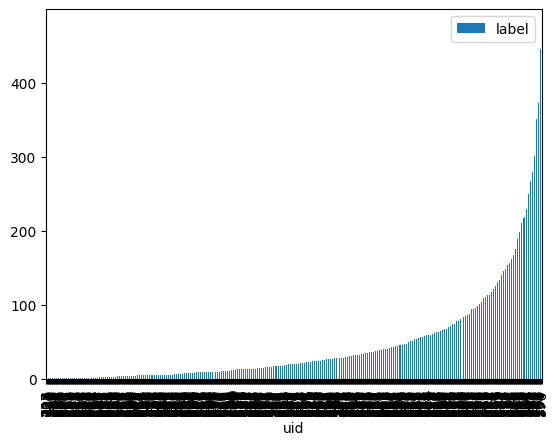

In [57]:
m = train_.groupby('uid').agg({'label':'count'}).sort_values('label').reset_index()
m.plot(x='uid',kind='bar')

In [58]:
train_.uid.max()



838

<Axes: xlabel='uid'>

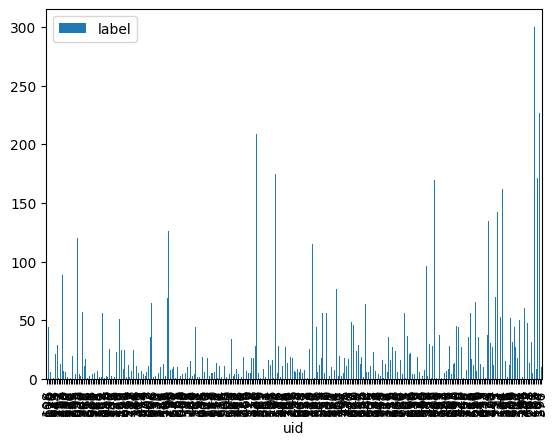

In [59]:
n = valid_.groupby('uid').agg({'label':'count'})
idx = []
a = valid_.uid.unique()
for x in m['uid'].values[:]:
    if x in a:
        idx.append(x)
n.loc[idx].reset_index().plot(x='uid',kind='bar')

<Axes: xlabel='uid'>

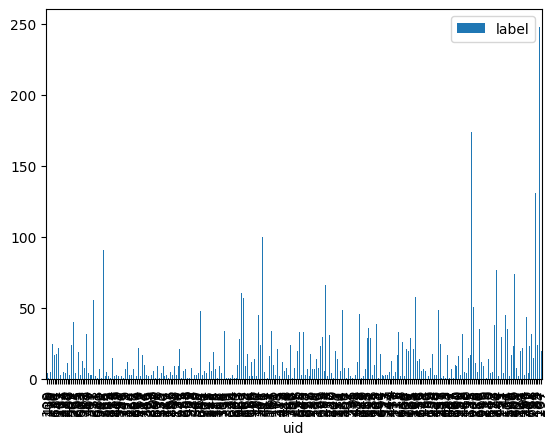

In [65]:
n = test_.groupby('uid').agg({'label':'count'})
idx = []
a = test_.uid.unique()
for x in m['uid'].values[:]:
    if x in a:
        idx.append(x)
n.loc[idx].reset_index().plot(x='uid',kind='bar')

In [61]:
save_path = "/data/zyang/datasets/ml-1m/"
train_ = pd.read_pickle(save_path+"train_ood2.pkl")
valid_ = pd.read_pickle(save_path+"valid_ood2.pkl")
test_ = pd.read_pickle(save_path+"test_ood2.pkl")

In [62]:
max(train_.uid.max(),test_.uid.max(),valid_.uid.max())+1, max(train_.iid.max(),test_.iid.max(),valid_.iid.max())+1


(839, 3256)

In [63]:
valid_small = pd.read_pickle(save_path+"valid_small_ood2.pkl")

In [64]:
valid_small.uid.max(), valid_small.iid.max()

(833, 3249)

In [2]:
import pandas as pd
save_path = "/data/zyang/datasets/ml-1m/"
# trai.to_pickle(save_path+"train_ood2.pkl")
valid_ = pd.read_pickle(save_path+"valid_ood2.pkl")
test_ = pd.read_pickle(save_path+"test_ood2.pkl")

In [3]:
valid_.not_cold.mean()

0.6354196711854629